# -*- coding: utf-8 -*-
# ---
# title: "WideResNet50_2 CIFAR-10 with advanced augmentations + checkpoint + multi-config comparison"
# author: "ChatGPT"
# ---

# # Giới thiệu
#
# Dataset CIFAR-10 gồm 60,000 ảnh nhỏ 32x32 màu, chia 10 lớp.
# Dữ liệu tải từ file pickle tại `/content/sample_data/data_batch_1`...`data_batch_5` và `test_batch`.
#
# Mục tiêu: huấn luyện mô hình WideResNet50_2 pretrained trên ImageNet, sử dụng Cutout, Mixup, CutMix, AutoAugment,
# lưu checkpoint theo epoch, huấn luyện tiếp tục nếu có checkpoint cũ,
# chạy thử 3 cấu hình siêu tham số khác nhau để so sánh.
#
# Lưu mô hình cuối cùng tại `/content/sample_data/mohinhcp10.pth`

# %% [markdown]

In [ ]:
# # 1. Import các thư viện cần thiết và khai báo các hàm load dữ liệu

In [ ]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision.models as models
import torchvision.datasets as datasets
import torchvision.transforms.autoaugment as autoaugment

from tqdm import tqdm

# Hàm load 1 batch data CIFAR-10 từ file pickle

In [ ]:
def load_cifar10_batch(batch_file):
    with open(batch_file, 'rb') as f:
        batch = pickle.load(f, encoding='bytes')
    data = batch[b'data']
    labels = batch[b'labels']
    data = data.reshape(-1, 3, 32, 32).astype(np.uint8)  # (N, 3, 32, 32)
    return data, np.array(labels)

# Load tất cả batch train + test

In [ ]:
def load_cifar10_data(data_dir='/content/sample_data'):
    x_train, y_train = [], []
    for i in range(1, 6):
        d, l = load_cifar10_batch(os.path.join(data_dir, f'data_batch_{i}'))
        x_train.append(d)
        y_train.append(l)
    x_train = np.concatenate(x_train, axis=0)
    y_train = np.concatenate(y_train, axis=0)
    x_test, y_test = load_cifar10_batch(os.path.join(data_dir, 'test_batch'))
    return x_train, y_train, x_test, y_test

# Dataset custom dùng PIL + transforms của torchvision để tiện augment

In [ ]:
class CIFAR10Dataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform
    def __len__(self):
        return len(self.images)
    def __getitem__(self, idx):
        img = Image.fromarray(np.transpose(self.images[idx], (1, 2, 0)))  # CHW to HWC
        label = self.labels[idx]
        if self.transform:
            img = self.transform(img)
        return img, label



# # 2. Hiện sơ lược dữ liệu

In [ ]:
x_train, y_train, x_test, y_test = load_cifar10_data()

print(f"Số lượng ảnh train: {x_train.shape[0]}")
print(f"Số lượng ảnh test: {x_test.shape[0]}")
print(f"Kích thước ảnh: {x_train.shape[2:]} (C, H, W)")

Số lượng ảnh train: 50000
Số lượng ảnh test: 10000
Kích thước ảnh: (32, 32) (C, H, W)


# Hiện 10 ảnh mẫu

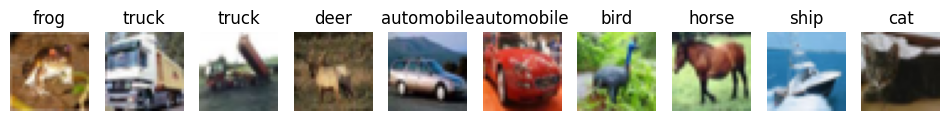

In [ ]:
plt.figure(figsize=(12, 3))
class_names = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']
for i in range(10):
    plt.subplot(1, 10, i+1)
    img = np.transpose(x_train[i], (1, 2, 0))  # CHW -> HWC
    plt.imshow(img)
    plt.title(class_names[y_train[i]])
    plt.axis('off')
plt.show()

In [ ]:
# # 3. Định nghĩa augmentations nâng cao: Cutout, Mixup, CutMix + AutoAugment


In [ ]:
def cutout(img, size=8):
    """Cắt 1 vùng vuông ngẫu nhiên trên ảnh (tensor C,H,W)"""
    c, h, w = img.shape
    y = np.random.randint(h)
    x = np.random.randint(w)
    y1 = np.clip(y - size // 2, 0, h)
    y2 = np.clip(y + size // 2, 0, h)
    x1 = np.clip(x - size // 2, 0, w)
    x2 = np.clip(x + size // 2, 0, w)
    img[:, y1:y2, x1:x2] = 0
    return img


def cutmix_data(x, y, alpha=1.0):
    """CutMix data"""
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1
    batch_size, c, h, w = x.size()
    index = torch.randperm(batch_size).to(x.device)
    y_a, y_b = y, y[index]
    bbx1, bby1, bbx2, bby2 = rand_bbox(h, w, lam)
    x[:, :, bby1:bby2, bbx1:bbx2] = x[index, :, bby1:bby2, bbx1:bbx2]
    lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (h * w))
    return x, y_a, y_b, lam

def rand_bbox(H, W, lam):
    cut_rat = np.sqrt(1. - lam)
    cut_w = int(W * cut_rat)
    cut_h = int(H * cut_rat)

    cx = np.random.randint(W)
    cy = np.random.randint(H)

    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)

    return bbx1, bby1, bbx2, bby2

# AutoAugment CIFAR10 policy có sẵn trong torchvision (PyTorch 1.13+)

In [ ]:
autoaugment_transform = autoaugment.AutoAugment(policy=autoaugment.AutoAugmentPolicy.CIFAR10)

train_transform = transforms.Compose([
    autoaugment_transform,
    transforms.ToTensor(),
    # Cutout được áp dụng thủ công trong training loop (tensor)
])

test_transform = transforms.Compose([
    transforms.ToTensor()
])

train_dataset = CIFAR10Dataset(x_train, y_train, transform=train_transform)
test_dataset = CIFAR10Dataset(x_test, y_test, transform=test_transform)

5. Định nghĩa mô hình WideResNet50_2 pretrained

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Sử dụng thiết bị: {device}")

model = models.wide_resnet50_2(pretrained=True)
# Thay thế fc để phù hợp CIFAR-10 (10 lớp)
model.fc = nn.Linear(model.fc.in_features, 10)
model = model.to(device)

Sử dụng thiết bị: cuda


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Wide_ResNet50_2_Weights.IMAGENET1K_V1`. You can also use `weights=Wide_ResNet50_2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/wide_resnet50_2-95faca4d.pth" to /root/.cache/torch/hub/checkpoints/wide_resnet50_2-95faca4d.pth
100%|██████████| 132M/132M [00:00<00:00, 147MB/s]


# # 6. Hàm train với Mixup, CutMix, Cutout kết hợp

In [ ]:
from torch.cuda.amp import autocast, GradScaler

def train_one_epoch(model, optimizer, criterion, dataloader, device,
                    alpha=1.0, cutout_size=8, use_cutmix=True, use_cutout=True, scaler=None):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, targets in tqdm(dataloader):
        inputs, targets = inputs.to(device), targets.to(device)
        targets_onehot = F.one_hot(targets, num_classes=10).float()

        if use_cutmix:
            # Áp dụng CutMix
            inputs, targets_a, targets_b, lam = cutmix_data(inputs, targets_onehot, alpha)
        elif use_cutout:
            # Áp dụng Cutout cho từng ảnh
            for i in range(inputs.size(0)):
                inputs[i] = cutout(inputs[i], cutout_size)
            lam = None  # Không dùng CutMix
        else:
            lam = None

        with autocast():
            outputs = model(inputs)

            if use_cutmix and lam is not None:
                loss = lam * criterion(outputs, targets_a) + (1 - lam) * criterion(outputs, targets_b)
            else:
                loss = criterion(outputs, targets)

        optimizer.zero_grad()
        if scaler:
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            loss.backward()
            optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = outputs.max(1)

        # Accuracy tính bằng nhãn gốc
        correct += predicted.eq(targets).sum().item()
        total += targets.size(0)

    epoch_loss = running_loss / total
    epoch_acc = 100. * correct / total
    return epoch_loss, epoch_acc


# # 7. Huấn luyện với checkpoint, 3 config siêu tham số

In [ ]:
from collections import defaultdict

checkpoint_dir = '/content/sample_data/checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)

num_epochs = 60

# Định nghĩa batch size riêng cho từng cấu hình
configs = [
    {'depth': 16, 'widen_factor': 10, 'lr': 0.01, 'weight_decay': 5e-4, 'alpha': 1.0, 'batch_size': 128, 'name': 'config1'},
    {'depth': 22, 'widen_factor': 8,  'lr': 0.005, 'weight_decay': 1e-4, 'alpha': 0.5, 'batch_size': 192, 'name': 'config2'},
    {'depth': 28, 'widen_factor': 6,  'lr': 0.02, 'weight_decay': 1e-3, 'alpha': 1.5, 'batch_size': 256,  'name': 'config3'},
]

results = defaultdict(lambda: {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []})

for config in configs:
    print(f"==== Bắt đầu huấn luyện {config['name']} ====")

    # Tạo lại data loader với batch size riêng
    train_loader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True, num_workers=2)
    test_loader = DataLoader(test_dataset, batch_size=config['batch_size'], shuffle=False, num_workers=2)

    # Khởi tạo mô hình
    model = models.wide_resnet50_2(pretrained=True)
    model.fc = nn.Linear(model.fc.in_features, 10)
    model = model.to(device)

    optimizer = optim.SGD(model.parameters(), lr=config['lr'], momentum=0.9, weight_decay=config['weight_decay'])
    criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

    scaler = GradScaler()

    for epoch in range(num_epochs):
      train_loss, train_acc = train_one_epoch(
        model, optimizer, criterion, train_loader, device,
        alpha=1.0, cutout_size=8, use_cutmix=True, use_cutout=True,
        scaler=scaler
    )

        val_loss, val_acc = evaluate(model, test_loader, criterion, device)

        print(f"Train loss: {train_loss:.4f}  acc: {train_acc:.2f}% | Val loss: {val_loss:.4f}  acc: {val_acc:.2f}%")

        results[config['name']]['train_loss'].append(train_loss)
        results[config['name']]['train_acc'].append(train_acc)
        results[config['name']]['val_loss'].append(val_loss)
        results[config['name']]['val_acc'].append(val_acc)

    # Lưu model chỉ sau khi huấn luyện xong toàn bộ epochs
    torch.save({
        'model_state': model.state_dict(),
        'optimizer_state': optimizer.state_dict(),
        'epoch': num_epochs - 1
    }, os.path.join(checkpoint_dir, f"checkpoint_{config['name']}_final.pth"))

    # Lưu model phục vụ nhận diện ảnh
    torch.save(model.state_dict(), f'/content/sample_data/mohinhcp10_{config["name"]}.pth')


==== Bắt đầu huấn luyện config1 ====
Epoch 1/60 - Config config1


100%|██████████| 391/391 [00:57<00:00,  6.85it/s]


Train loss: 1.9233  acc: 32.02% | Val loss: 1.1491  acc: 64.02%
Epoch 2/60 - Config config1


100%|██████████| 391/391 [00:56<00:00,  6.88it/s]


Train loss: 1.6656  acc: 41.12% | Val loss: 0.8693  acc: 74.18%
Epoch 3/60 - Config config1


100%|██████████| 391/391 [00:56<00:00,  6.86it/s]


Train loss: 1.5365  acc: 46.59% | Val loss: 0.8135  acc: 75.25%
Epoch 4/60 - Config config1


100%|██████████| 391/391 [00:56<00:00,  6.86it/s]


Train loss: 1.4607  acc: 48.56% | Val loss: 0.9390  acc: 70.88%
Epoch 5/60 - Config config1


100%|██████████| 391/391 [00:56<00:00,  6.86it/s]


Train loss: 1.4182  acc: 48.46% | Val loss: 0.7947  acc: 77.02%
Epoch 6/60 - Config config1


100%|██████████| 391/391 [00:56<00:00,  6.90it/s]


Train loss: 1.3872  acc: 51.35% | Val loss: 0.7518  acc: 79.78%
Epoch 7/60 - Config config1


100%|██████████| 391/391 [00:56<00:00,  6.90it/s]


Train loss: 1.3484  acc: 53.66% | Val loss: 0.6878  acc: 81.78%
Epoch 8/60 - Config config1


100%|██████████| 391/391 [00:57<00:00,  6.85it/s]


Train loss: 1.2854  acc: 53.09% | Val loss: 0.7373  acc: 81.15%
Epoch 9/60 - Config config1


100%|██████████| 391/391 [00:56<00:00,  6.88it/s]


Train loss: 1.2743  acc: 55.59% | Val loss: 0.6779  acc: 82.25%
Epoch 10/60 - Config config1


100%|██████████| 391/391 [00:56<00:00,  6.91it/s]


Train loss: 1.2130  acc: 57.56% | Val loss: 2.6804  acc: 27.17%
Epoch 11/60 - Config config1


100%|██████████| 391/391 [00:57<00:00,  6.86it/s]


Train loss: 1.4231  acc: 49.52% | Val loss: 0.7237  acc: 80.46%
Epoch 12/60 - Config config1


100%|██████████| 391/391 [00:56<00:00,  6.87it/s]


Train loss: 1.2799  acc: 54.08% | Val loss: 0.7724  acc: 79.63%
Epoch 13/60 - Config config1


100%|██████████| 391/391 [00:57<00:00,  6.84it/s]


Train loss: 1.2486  acc: 55.55% | Val loss: 0.7428  acc: 80.43%
Epoch 14/60 - Config config1


100%|██████████| 391/391 [00:56<00:00,  6.86it/s]


Train loss: 1.2682  acc: 53.99% | Val loss: 0.6276  acc: 82.20%
Epoch 15/60 - Config config1


100%|██████████| 391/391 [00:57<00:00,  6.85it/s]


Train loss: 1.2650  acc: 54.96% | Val loss: 0.7100  acc: 80.60%
Epoch 16/60 - Config config1


100%|██████████| 391/391 [00:56<00:00,  6.91it/s]


Train loss: 1.2622  acc: 53.94% | Val loss: 0.6263  acc: 83.41%
Epoch 17/60 - Config config1


100%|██████████| 391/391 [00:56<00:00,  6.92it/s]


Train loss: 1.2509  acc: 54.21% | Val loss: 0.6864  acc: 81.90%
Epoch 18/60 - Config config1


100%|██████████| 391/391 [00:56<00:00,  6.94it/s]


Train loss: 1.2262  acc: 56.87% | Val loss: 0.6379  acc: 82.98%
Epoch 19/60 - Config config1


100%|██████████| 391/391 [00:57<00:00,  6.84it/s]


Train loss: 1.1801  acc: 59.17% | Val loss: 0.5704  acc: 84.92%
Epoch 20/60 - Config config1


100%|██████████| 391/391 [00:56<00:00,  6.92it/s]


Train loss: 1.1477  acc: 58.34% | Val loss: 0.6140  acc: 82.58%
Epoch 21/60 - Config config1


100%|██████████| 391/391 [00:56<00:00,  6.89it/s]


Train loss: 1.1716  acc: 55.97% | Val loss: 0.8160  acc: 78.09%
Epoch 22/60 - Config config1


100%|██████████| 391/391 [00:56<00:00,  6.90it/s]


Train loss: 1.1878  acc: 57.99% | Val loss: 0.6353  acc: 82.20%
Epoch 23/60 - Config config1


100%|██████████| 391/391 [00:57<00:00,  6.82it/s]


Train loss: 1.1317  acc: 58.61% | Val loss: 0.5572  acc: 83.56%
Epoch 24/60 - Config config1


100%|██████████| 391/391 [00:56<00:00,  6.89it/s]


Train loss: 1.1568  acc: 58.81% | Val loss: 0.6949  acc: 80.55%
Epoch 25/60 - Config config1


100%|██████████| 391/391 [00:56<00:00,  6.93it/s]


Train loss: 1.1592  acc: 58.26% | Val loss: 0.6315  acc: 83.28%
Epoch 26/60 - Config config1


100%|██████████| 391/391 [00:57<00:00,  6.82it/s]


Train loss: 1.1386  acc: 59.15% | Val loss: 0.7108  acc: 79.79%
Epoch 27/60 - Config config1


100%|██████████| 391/391 [00:57<00:00,  6.86it/s]


Train loss: 1.1173  acc: 60.68% | Val loss: 0.5859  acc: 82.87%
Epoch 28/60 - Config config1


100%|██████████| 391/391 [00:56<00:00,  6.87it/s]


Train loss: 1.1565  acc: 58.75% | Val loss: 0.5770  acc: 85.87%
Epoch 29/60 - Config config1


100%|██████████| 391/391 [00:56<00:00,  6.87it/s]


Train loss: 1.1328  acc: 61.14% | Val loss: 0.6887  acc: 81.19%
Epoch 30/60 - Config config1


100%|██████████| 391/391 [00:56<00:00,  6.88it/s]


Train loss: 1.1206  acc: 59.93% | Val loss: 0.6422  acc: 83.83%
Epoch 31/60 - Config config1


100%|██████████| 391/391 [00:57<00:00,  6.85it/s]


Train loss: 1.1307  acc: 59.51% | Val loss: 0.6364  acc: 81.43%
Epoch 32/60 - Config config1


100%|██████████| 391/391 [00:56<00:00,  6.87it/s]


Train loss: 1.1720  acc: 59.01% | Val loss: 0.8269  acc: 78.32%
Epoch 33/60 - Config config1


100%|██████████| 391/391 [00:56<00:00,  6.88it/s]


Train loss: 1.1260  acc: 57.96% | Val loss: 0.7433  acc: 79.72%
Epoch 34/60 - Config config1


100%|██████████| 391/391 [00:56<00:00,  6.90it/s]


Train loss: 1.1165  acc: 60.30% | Val loss: 0.6093  acc: 82.48%
Epoch 35/60 - Config config1


100%|██████████| 391/391 [00:57<00:00,  6.83it/s]


Train loss: 1.1305  acc: 60.62% | Val loss: 0.5765  acc: 84.41%
Epoch 36/60 - Config config1


100%|██████████| 391/391 [00:57<00:00,  6.82it/s]


Train loss: 1.1256  acc: 59.63% | Val loss: 0.6379  acc: 82.91%
Epoch 37/60 - Config config1


100%|██████████| 391/391 [00:56<00:00,  6.86it/s]


Train loss: 1.1243  acc: 59.44% | Val loss: 0.6380  acc: 84.21%
Epoch 38/60 - Config config1


100%|██████████| 391/391 [00:57<00:00,  6.82it/s]


Train loss: 1.1027  acc: 60.73% | Val loss: 0.7380  acc: 79.67%
Epoch 39/60 - Config config1


100%|██████████| 391/391 [00:56<00:00,  6.89it/s]


Train loss: 1.0955  acc: 58.65% | Val loss: 0.6293  acc: 83.74%
Epoch 40/60 - Config config1


100%|██████████| 391/391 [00:56<00:00,  6.87it/s]


Train loss: 1.1303  acc: 60.60% | Val loss: 0.5748  acc: 84.40%
Epoch 41/60 - Config config1


100%|██████████| 391/391 [00:56<00:00,  6.90it/s]


Train loss: 1.1120  acc: 60.07% | Val loss: 0.6166  acc: 83.77%
Epoch 42/60 - Config config1


100%|██████████| 391/391 [00:56<00:00,  6.87it/s]


Train loss: 1.1103  acc: 60.82% | Val loss: 0.5724  acc: 84.54%
Epoch 43/60 - Config config1


100%|██████████| 391/391 [00:56<00:00,  6.89it/s]


Train loss: 1.1348  acc: 57.49% | Val loss: 0.6210  acc: 83.24%
Epoch 44/60 - Config config1


100%|██████████| 391/391 [00:57<00:00,  6.84it/s]


Train loss: 1.0475  acc: 61.82% | Val loss: 0.7430  acc: 78.22%
Epoch 45/60 - Config config1


100%|██████████| 391/391 [00:56<00:00,  6.87it/s]


Train loss: 1.1326  acc: 60.43% | Val loss: 0.6103  acc: 83.15%
Epoch 46/60 - Config config1


100%|██████████| 391/391 [00:56<00:00,  6.86it/s]


Train loss: 1.0978  acc: 59.48% | Val loss: 0.6337  acc: 82.47%
Epoch 47/60 - Config config1


100%|██████████| 391/391 [00:57<00:00,  6.84it/s]


Train loss: 1.1220  acc: 60.70% | Val loss: 0.5936  acc: 82.96%
Epoch 48/60 - Config config1


100%|██████████| 391/391 [00:57<00:00,  6.86it/s]


Train loss: 1.0782  acc: 60.94% | Val loss: 0.6618  acc: 82.33%
Epoch 49/60 - Config config1


100%|██████████| 391/391 [00:57<00:00,  6.80it/s]


Train loss: 1.0879  acc: 60.99% | Val loss: 0.6064  acc: 83.97%
Epoch 50/60 - Config config1


100%|██████████| 391/391 [00:56<00:00,  6.87it/s]


Train loss: 1.0153  acc: 64.28% | Val loss: 0.6375  acc: 82.31%
Epoch 51/60 - Config config1


100%|██████████| 391/391 [00:56<00:00,  6.87it/s]


Train loss: 1.1318  acc: 57.78% | Val loss: 0.5957  acc: 85.49%
Epoch 52/60 - Config config1


100%|██████████| 391/391 [00:57<00:00,  6.81it/s]


Train loss: 1.0781  acc: 60.24% | Val loss: 0.5534  acc: 84.26%
Epoch 53/60 - Config config1


100%|██████████| 391/391 [00:57<00:00,  6.85it/s]


Train loss: 1.1017  acc: 62.51% | Val loss: 0.5626  acc: 84.45%
Epoch 54/60 - Config config1


100%|██████████| 391/391 [00:57<00:00,  6.80it/s]


Train loss: 1.0959  acc: 58.97% | Val loss: 0.7535  acc: 78.64%
Epoch 55/60 - Config config1


100%|██████████| 391/391 [00:57<00:00,  6.85it/s]


Train loss: 1.1145  acc: 60.84% | Val loss: 0.6944  acc: 80.61%
Epoch 56/60 - Config config1


100%|██████████| 391/391 [00:57<00:00,  6.82it/s]


Train loss: 1.0526  acc: 62.25% | Val loss: 0.5857  acc: 85.11%
Epoch 57/60 - Config config1


100%|██████████| 391/391 [00:57<00:00,  6.82it/s]


Train loss: 1.0870  acc: 59.89% | Val loss: 0.6766  acc: 82.06%
Epoch 58/60 - Config config1


100%|██████████| 391/391 [00:57<00:00,  6.84it/s]


Train loss: 1.0584  acc: 60.58% | Val loss: 0.5442  acc: 84.77%
Epoch 59/60 - Config config1


100%|██████████| 391/391 [00:57<00:00,  6.80it/s]


Train loss: 1.0936  acc: 62.56% | Val loss: 0.6456  acc: 82.54%
Epoch 60/60 - Config config1


100%|██████████| 391/391 [00:56<00:00,  6.87it/s]


Train loss: 1.1091  acc: 61.78% | Val loss: 0.6237  acc: 83.87%
==== Bắt đầu huấn luyện config2 ====
Epoch 1/60 - Config config2


100%|██████████| 391/391 [00:57<00:00,  6.83it/s]


Train loss: 1.7928  acc: 32.79% | Val loss: 0.9147  acc: 71.64%
Epoch 2/60 - Config config2


100%|██████████| 391/391 [00:56<00:00,  6.87it/s]


Train loss: 1.3995  acc: 48.93% | Val loss: 0.7214  acc: 77.05%
Epoch 3/60 - Config config2


100%|██████████| 391/391 [00:57<00:00,  6.85it/s]


Train loss: 1.3493  acc: 50.78% | Val loss: 0.6512  acc: 78.92%
Epoch 4/60 - Config config2


100%|██████████| 391/391 [00:57<00:00,  6.85it/s]


Train loss: 1.2545  acc: 53.52% | Val loss: 0.5861  acc: 82.08%
Epoch 5/60 - Config config2


100%|██████████| 391/391 [00:56<00:00,  6.88it/s]


Train loss: 1.2616  acc: 51.28% | Val loss: 0.7604  acc: 79.15%
Epoch 6/60 - Config config2


100%|██████████| 391/391 [00:56<00:00,  6.86it/s]


Train loss: 1.2416  acc: 51.43% | Val loss: 0.5083  acc: 84.47%
Epoch 7/60 - Config config2


100%|██████████| 391/391 [00:57<00:00,  6.83it/s]


Train loss: 1.1449  acc: 56.90% | Val loss: 0.5241  acc: 85.24%
Epoch 8/60 - Config config2


100%|██████████| 391/391 [00:57<00:00,  6.82it/s]


Train loss: 1.1052  acc: 58.52% | Val loss: 0.5678  acc: 85.69%
Epoch 9/60 - Config config2


100%|██████████| 391/391 [00:58<00:00,  6.71it/s]


Train loss: 1.0887  acc: 56.38% | Val loss: 0.4767  acc: 85.97%
Epoch 10/60 - Config config2


100%|██████████| 391/391 [00:57<00:00,  6.81it/s]


Train loss: 1.1020  acc: 57.68% | Val loss: 0.4600  acc: 86.52%
Epoch 11/60 - Config config2


100%|██████████| 391/391 [00:57<00:00,  6.85it/s]


Train loss: 1.0584  acc: 57.31% | Val loss: 0.4805  acc: 86.22%
Epoch 12/60 - Config config2


100%|██████████| 391/391 [00:57<00:00,  6.82it/s]


Train loss: 1.0652  acc: 59.08% | Val loss: 0.5468  acc: 83.60%
Epoch 13/60 - Config config2


100%|██████████| 391/391 [00:57<00:00,  6.84it/s]


Train loss: 1.0290  acc: 57.92% | Val loss: 0.5814  acc: 86.16%
Epoch 14/60 - Config config2


100%|██████████| 391/391 [00:56<00:00,  6.87it/s]


Train loss: 1.0438  acc: 58.20% | Val loss: 0.5419  acc: 84.45%
Epoch 15/60 - Config config2


100%|██████████| 391/391 [00:56<00:00,  6.86it/s]


Train loss: 1.0033  acc: 58.31% | Val loss: 0.4863  acc: 86.54%
Epoch 16/60 - Config config2


100%|██████████| 391/391 [00:57<00:00,  6.79it/s]


Train loss: 1.0265  acc: 60.37% | Val loss: 0.4729  acc: 86.69%
Epoch 17/60 - Config config2


100%|██████████| 391/391 [00:57<00:00,  6.81it/s]


Train loss: 1.0386  acc: 60.66% | Val loss: 0.4821  acc: 87.30%
Epoch 18/60 - Config config2


100%|██████████| 391/391 [00:57<00:00,  6.84it/s]


Train loss: 0.9838  acc: 60.98% | Val loss: 0.5076  acc: 87.72%
Epoch 19/60 - Config config2


100%|██████████| 391/391 [00:57<00:00,  6.79it/s]


Train loss: 1.0151  acc: 61.79% | Val loss: 0.4699  acc: 87.30%
Epoch 20/60 - Config config2


100%|██████████| 391/391 [00:57<00:00,  6.80it/s]


Train loss: 0.9403  acc: 63.47% | Val loss: 0.4661  acc: 87.77%
Epoch 21/60 - Config config2


100%|██████████| 391/391 [00:57<00:00,  6.82it/s]


Train loss: 0.9316  acc: 63.68% | Val loss: 0.4855  acc: 87.27%
Epoch 22/60 - Config config2


100%|██████████| 391/391 [00:57<00:00,  6.81it/s]


Train loss: 0.9545  acc: 62.24% | Val loss: 0.4276  acc: 87.61%
Epoch 23/60 - Config config2


100%|██████████| 391/391 [00:57<00:00,  6.78it/s]


Train loss: 0.9616  acc: 60.37% | Val loss: 0.4635  acc: 87.40%
Epoch 24/60 - Config config2


100%|██████████| 391/391 [00:57<00:00,  6.82it/s]


Train loss: 0.9154  acc: 61.28% | Val loss: 0.4482  acc: 87.70%
Epoch 25/60 - Config config2


100%|██████████| 391/391 [00:57<00:00,  6.86it/s]


Train loss: 0.9527  acc: 62.05% | Val loss: 0.4207  acc: 88.30%
Epoch 26/60 - Config config2


100%|██████████| 391/391 [00:56<00:00,  6.90it/s]


Train loss: 1.0330  acc: 59.30% | Val loss: 0.4850  acc: 87.31%
Epoch 27/60 - Config config2


100%|██████████| 391/391 [00:56<00:00,  6.89it/s]


Train loss: 0.9630  acc: 62.08% | Val loss: 0.4398  acc: 87.57%
Epoch 28/60 - Config config2


100%|██████████| 391/391 [00:57<00:00,  6.81it/s]


Train loss: 0.9254  acc: 63.55% | Val loss: 0.4810  acc: 85.72%
Epoch 29/60 - Config config2


100%|██████████| 391/391 [00:57<00:00,  6.79it/s]


Train loss: 0.9376  acc: 61.96% | Val loss: 0.5052  acc: 86.22%
Epoch 30/60 - Config config2


100%|██████████| 391/391 [00:57<00:00,  6.83it/s]


Train loss: 0.8932  acc: 64.91% | Val loss: 0.3927  acc: 88.48%
Epoch 31/60 - Config config2


100%|██████████| 391/391 [00:57<00:00,  6.82it/s]


Train loss: 0.9619  acc: 64.33% | Val loss: 0.5882  acc: 84.35%
Epoch 32/60 - Config config2


100%|██████████| 391/391 [00:57<00:00,  6.84it/s]


Train loss: 0.8719  acc: 63.93% | Val loss: 0.4243  acc: 87.83%
Epoch 33/60 - Config config2


100%|██████████| 391/391 [00:57<00:00,  6.83it/s]


Train loss: 0.8917  acc: 63.57% | Val loss: 0.4288  acc: 87.95%
Epoch 34/60 - Config config2


100%|██████████| 391/391 [00:57<00:00,  6.80it/s]


Train loss: 0.8764  acc: 64.00% | Val loss: 0.4184  acc: 87.92%
Epoch 35/60 - Config config2


100%|██████████| 391/391 [00:57<00:00,  6.82it/s]


Train loss: 0.9568  acc: 58.85% | Val loss: 0.4258  acc: 87.84%
Epoch 36/60 - Config config2


100%|██████████| 391/391 [00:57<00:00,  6.84it/s]


Train loss: 0.8687  acc: 64.26% | Val loss: 0.4541  acc: 88.84%
Epoch 37/60 - Config config2


100%|██████████| 391/391 [00:57<00:00,  6.82it/s]


Train loss: 0.8473  acc: 65.01% | Val loss: 0.4857  acc: 87.81%
Epoch 38/60 - Config config2


100%|██████████| 391/391 [00:56<00:00,  6.86it/s]


Train loss: 0.8532  acc: 62.12% | Val loss: 0.4077  acc: 88.53%
Epoch 39/60 - Config config2


100%|██████████| 391/391 [00:57<00:00,  6.85it/s]


Train loss: 0.8990  acc: 63.72% | Val loss: 0.4333  acc: 88.24%
Epoch 40/60 - Config config2


100%|██████████| 391/391 [00:57<00:00,  6.84it/s]


Train loss: 0.8828  acc: 63.17% | Val loss: 0.4604  acc: 87.26%
Epoch 41/60 - Config config2


100%|██████████| 391/391 [00:57<00:00,  6.82it/s]


Train loss: 0.8993  acc: 62.03% | Val loss: 0.4620  acc: 88.62%
Epoch 42/60 - Config config2


100%|██████████| 391/391 [00:58<00:00,  6.69it/s]


Train loss: 0.8514  acc: 64.42% | Val loss: 0.5071  acc: 86.71%
Epoch 43/60 - Config config2


100%|██████████| 391/391 [01:01<00:00,  6.31it/s]


Train loss: 0.8933  acc: 62.18% | Val loss: 0.3972  acc: 88.47%
Epoch 44/60 - Config config2


100%|██████████| 391/391 [00:57<00:00,  6.82it/s]


Train loss: 0.9141  acc: 63.84% | Val loss: 0.4078  acc: 87.85%
Epoch 45/60 - Config config2


100%|██████████| 391/391 [00:57<00:00,  6.82it/s]


Train loss: 0.8511  acc: 65.78% | Val loss: 0.5184  acc: 86.97%
Epoch 46/60 - Config config2


100%|██████████| 391/391 [00:57<00:00,  6.84it/s]


Train loss: 0.8545  acc: 64.35% | Val loss: 0.4144  acc: 88.72%
Epoch 47/60 - Config config2


100%|██████████| 391/391 [00:57<00:00,  6.82it/s]


Train loss: 0.8570  acc: 62.61% | Val loss: 0.4210  acc: 88.27%
Epoch 48/60 - Config config2


100%|██████████| 391/391 [00:57<00:00,  6.83it/s]


Train loss: 0.8423  acc: 65.42% | Val loss: 0.3899  acc: 89.05%
Epoch 49/60 - Config config2


100%|██████████| 391/391 [00:57<00:00,  6.80it/s]


Train loss: 0.8594  acc: 65.77% | Val loss: 0.4050  acc: 88.79%
Epoch 50/60 - Config config2


100%|██████████| 391/391 [00:57<00:00,  6.84it/s]


Train loss: 0.8297  acc: 64.40% | Val loss: 0.4056  acc: 88.80%
Epoch 51/60 - Config config2


100%|██████████| 391/391 [00:57<00:00,  6.79it/s]


Train loss: 0.8674  acc: 60.85% | Val loss: 0.4437  acc: 87.36%
Epoch 52/60 - Config config2


100%|██████████| 391/391 [00:57<00:00,  6.83it/s]


Train loss: 0.8761  acc: 63.49% | Val loss: 0.4488  acc: 87.89%
Epoch 53/60 - Config config2


100%|██████████| 391/391 [00:57<00:00,  6.85it/s]


Train loss: 0.8349  acc: 67.16% | Val loss: 0.3879  acc: 88.92%
Epoch 54/60 - Config config2


100%|██████████| 391/391 [00:57<00:00,  6.82it/s]


Train loss: 0.8905  acc: 65.56% | Val loss: 0.4843  acc: 87.24%
Epoch 55/60 - Config config2


100%|██████████| 391/391 [00:56<00:00,  6.88it/s]


Train loss: 0.8309  acc: 65.34% | Val loss: 0.4357  acc: 88.34%
Epoch 56/60 - Config config2


100%|██████████| 391/391 [00:57<00:00,  6.84it/s]


Train loss: 0.8799  acc: 65.06% | Val loss: 0.4404  acc: 87.67%
Epoch 57/60 - Config config2


100%|██████████| 391/391 [00:57<00:00,  6.80it/s]


Train loss: 0.8267  acc: 66.78% | Val loss: 0.5225  acc: 86.50%
Epoch 58/60 - Config config2


100%|██████████| 391/391 [00:57<00:00,  6.86it/s]


Train loss: 0.8735  acc: 65.73% | Val loss: 0.4518  acc: 88.01%
Epoch 59/60 - Config config2


100%|██████████| 391/391 [00:57<00:00,  6.79it/s]


Train loss: 0.8611  acc: 64.84% | Val loss: 0.6209  acc: 85.49%
Epoch 60/60 - Config config2


100%|██████████| 391/391 [00:57<00:00,  6.80it/s]


Train loss: 0.8978  acc: 64.11% | Val loss: 0.5321  acc: 86.82%
==== Bắt đầu huấn luyện config3 ====
Epoch 1/60 - Config config3


100%|██████████| 391/391 [00:56<00:00,  6.87it/s]


Train loss: 2.2765  acc: 19.39% | Val loss: 2.3222  acc: 12.71%
Epoch 2/60 - Config config3


100%|██████████| 391/391 [00:57<00:00,  6.82it/s]


Train loss: 2.3025  acc: 13.67% | Val loss: 2.0265  acc: 22.55%
Epoch 3/60 - Config config3


100%|██████████| 391/391 [00:57<00:00,  6.83it/s]


Train loss: 2.1786  acc: 18.75% | Val loss: 1.7642  acc: 34.44%
Epoch 4/60 - Config config3


100%|██████████| 391/391 [00:57<00:00,  6.81it/s]


Train loss: 2.0806  acc: 23.74% | Val loss: 1.7195  acc: 38.31%
Epoch 5/60 - Config config3


100%|██████████| 391/391 [00:57<00:00,  6.86it/s]


KeyboardInterrupt: 

# # 8. Vẽ biểu đồ loss và accuracy

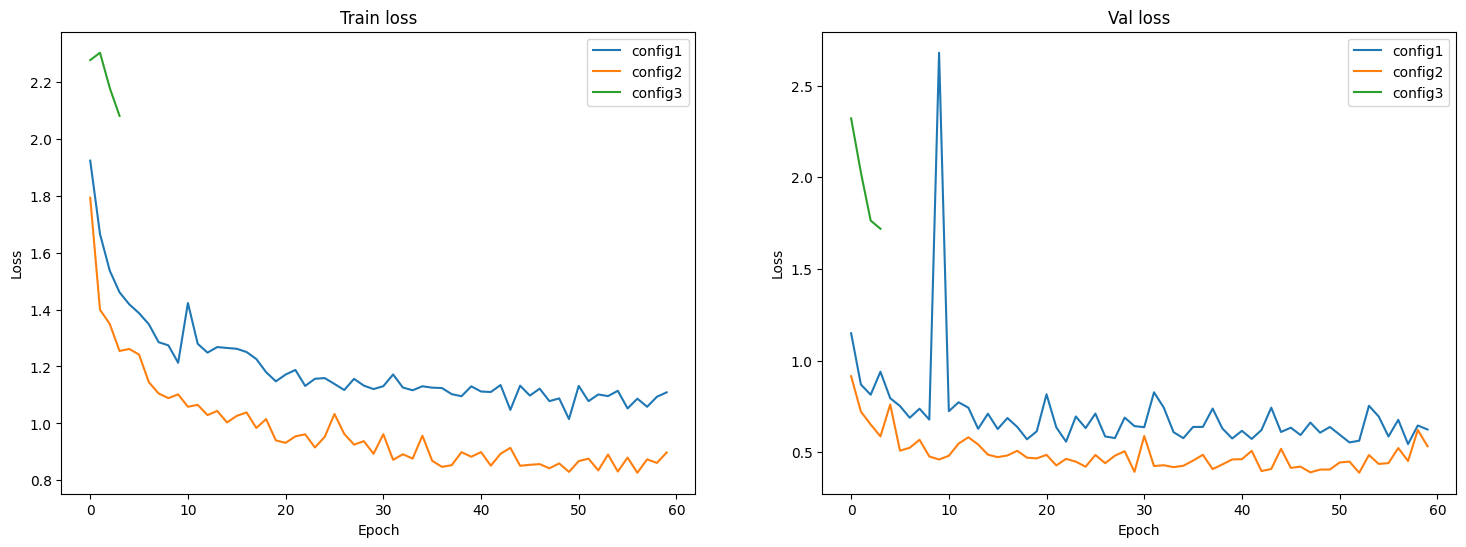

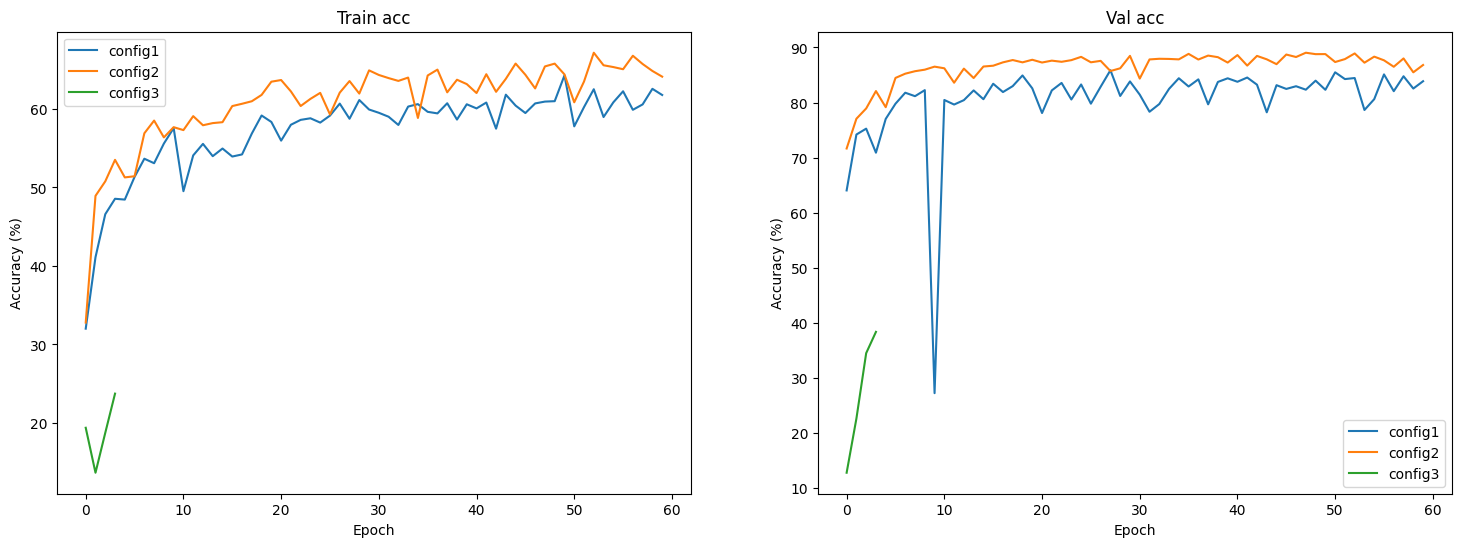

In [ ]:
plt.figure(figsize=(18, 6))

for i, metric in enumerate(['train_loss', 'val_loss']):
    plt.subplot(1, 2, i+1)
    for config in configs:
        plt.plot(results[config['name']][metric], label=config['name'])
    plt.title(metric.replace('_', ' ').capitalize())
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

plt.show()

plt.figure(figsize=(18, 6))

for i, metric in enumerate(['train_acc', 'val_acc']):
    plt.subplot(1, 2, i+1)
    for config in configs:
        plt.plot(results[config['name']][metric], label=config['name'])
    plt.title(metric.replace('_', ' ').capitalize())
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()

plt.show()

# %% [markdown]
# # Kết luận
# - Với 3 cấu hình siêu tham số khác nhau, ta có thể quan sát được biểu đồ loss và accuracy để lựa chọn config phù hợp nhất.
# - Mô hình WideResNet50_2 pretrained + augmentations Cutout, Mixup, CutMix, AutoAugment giúp cải thiện khả năng tổng quát.
# - Mô hình cuối cùng được lưu tại `/content/sample_data/mohinhcp10_{config_name}.pth` sẵn sàng deploy cho web nhận diện ảnh.
